In [1]:
# Instalar librerias
# !pip install yfinance
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

In [3]:
# Definir los tickers de las 100 empresas más grandes del S&P 500
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'BRK-B', 'JNJ', 'V', 'WMT',
    'PG', 'MA', 'UNH', 'DIS', 'NVDA', 'HD', 'PYPL', 'BAC', 'VZ', 'CMCSA',
    'NFLX', 'ADBE', 'INTC', 'CRM', 'PEP', 'CSCO', 'KO', 'T', 'PFE', 'MRK',
    'ABT', 'ABBV', 'NKE', 'ORCL', 'ACN', 'QCOM', 'TXN', 'AVGO', 'COST', 'DHR',
    'MDT', 'MCD', 'NEE', 'LIN', 'BMY', 'HON', 'LOW', 'UNP', 'UPS', 'SBUX',
    'AMGN', 'TMO', 'CVX', 'XOM', 'BA', 'CAT', 'MMM', 'GE', 'GS', 'JPM',
    'WFC', 'C', 'BLK', 'AXP', 'SPGI', 'RTX', 'DE', 'NOW', 'PLD', 'LMT',
    'CHTR', 'CI', 'CME', 'COP', 'COST', 'D', 'DUK', 'EL', 'EMR',
    'EXC', 'FIS', 'GD', 'GILD', 'GM', 'IBM', 'INTU', 'ISRG', 'LRCX',
    'MO', 'NOC', 'PNC', 'REGN', 'SO', 'SYK', 'TGT', 'TJX', 'USB', 'ZTS'
]

# Definir el período de tiempo para los datos históricos
start_date = '2018-01-01'
end_date = '2023-01-01'

In [4]:
# Descargar los datos históricos de los tickers
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Eliminar las columnas con valores nulos (si las hay)
data.dropna(axis=1, inplace=True)

[*********************100%***********************]  96 of 96 completed


In [5]:
# Calcular los retornos diarios
returns = data.pct_change().dropna()

# Calcular la matriz de covarianza
cov_matrix = returns.cov() * 252

In [6]:
# Función para calcular el rendimiento y la volatilidad de la cartera
def portfolio_performance(weights, returns, cov_matrix):
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

# Función para minimizar la volatilidad de la cartera
def minimize_volatility(weights, returns, cov_matrix):
    return portfolio_performance(weights, returns, cov_matrix)[1]

# Función para maximizar el ratio de Sharpe
def maximize_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    ret, vol = portfolio_performance(weights, returns, cov_matrix)
    return -(ret - risk_free_rate) / vol

# Función para verificar que la suma de los pesos sea 1
def check_sum(weights):
    return np.sum(weights) - 1

In [7]:
# Número de activos en la cartera
num_assets = len(returns.columns)

# Restricciones y límites para la optimización
constraints = ({'type': 'eq', 'fun': check_sum})
bounds = tuple((0, 1) for _ in range(num_assets))

# Optimización para la cartera de mínima volatilidad
initial_guess = num_assets * [1. / num_assets]
optimal_vol = sco.minimize(minimize_volatility, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimización para la cartera de máximo ratio de Sharpe
optimal_sharpe = sco.minimize(maximize_sharpe_ratio, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

In [12]:
# Resultados de la cartera de mínima volatilidad
min_vol_ret, min_vol_vol = portfolio_performance(optimal_vol.x, returns, cov_matrix)
min_vol_weights = dict(zip(returns.columns, optimal_vol.x))
sorted_min_vol_weights = {k: round(v, 3) for k, v in sorted(min_vol_weights.items(), key=lambda item: item[1], reverse=True)}

print("Cartera de Mínima Volatilidad:")
print(f"Retorno Anual: {min_vol_ret:.2%}")
print(f"Volatilidad Anual: {min_vol_vol:.2%}")
print("Pesos de la cartera (ordenados de mayor a menor):")
print(sorted_min_vol_weights)
print(f"Suma de las ponderaciones: {np.sum(optimal_vol.x):.4f}")

# Resultados de la cartera de máximo ratio de Sharpe
max_sharpe_ret, max_sharpe_vol = portfolio_performance(optimal_sharpe.x, returns, cov_matrix)
max_sharpe_weights = dict(zip(returns.columns, optimal_sharpe.x))
sorted_max_sharpe_weights = {k: round(v, 3) for k, v in sorted(max_sharpe_weights.items(), key=lambda item: item[1], reverse=True)}

print("\nCartera de Máximo Ratio de Sharpe:")
print(f"Retorno Anual: {max_sharpe_ret:.2%}")
print(f"Volatilidad Anual: {max_sharpe_vol:.2%}")
print("Pesos de la cartera (ordenados de mayor a menor):")
print(sorted_max_sharpe_weights)
print(f"Suma de las ponderaciones: {np.sum(optimal_sharpe.x):.4f}")

Cartera de Mínima Volatilidad:
Retorno Anual: 8.65%
Volatilidad Anual: 15.64%
Pesos de la cartera (ordenados de mayor a menor):
{'VZ': 0.263, 'WMT': 0.14, 'BMY': 0.117, 'MCD': 0.093, 'JNJ': 0.078, 'MO': 0.054, 'KO': 0.053, 'GILD': 0.05, 'MRK': 0.048, 'AMZN': 0.029, 'COST': 0.021, 'CHTR': 0.017, 'REGN': 0.012, 'LMT': 0.012, 'PFE': 0.007, 'UPS': 0.003, 'NFLX': 0.002, 'PG': 0.002, 'NOC': 0.0, 'LRCX': 0.0, 'CI': 0.0, 'C': 0.0, 'D': 0.0, 'DUK': 0.0, 'ISRG': 0.0, 'HON': 0.0, 'GE': 0.0, 'AAPL': 0.0, 'PYPL': 0.0, 'NVDA': 0.0, 'USB': 0.0, 'SO': 0.0, 'TSLA': 0.0, 'MDT': 0.0, 'V': 0.0, 'DHR': 0.0, 'HD': 0.0, 'ORCL': 0.0, 'AMGN': 0.0, 'CME': 0.0, 'INTC': 0.0, 'MMM': 0.0, 'GM': 0.0, 'TJX': 0.0, 'WFC': 0.0, 'NOW': 0.0, 'SYK': 0.0, 'MA': 0.0, 'XOM': 0.0, 'PNC': 0.0, 'SBUX': 0.0, 'AXP': 0.0, 'EXC': 0.0, 'EMR': 0.0, 'T': 0.0, 'NEE': 0.0, 'PLD': 0.0, 'EL': 0.0, 'QCOM': 0.0, 'CRM': 0.0, 'ABBV': 0.0, 'ABT': 0.0, 'ACN': 0.0, 'ADBE': 0.0, 'AVGO': 0.0, 'BA': 0.0, 'BAC': 0.0, 'BLK': 0.0, 'BRK-B': 0.0, 'CAT': 

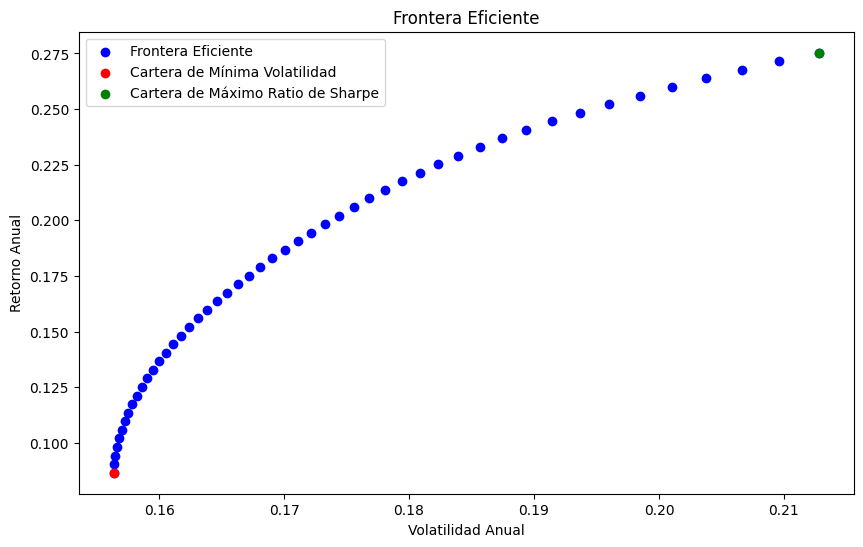

In [9]:
# Función para generar la frontera eficiente
def efficient_frontier(returns, cov_matrix, risk_free_rate=0.02):
    target_returns = np.linspace(min_vol_ret, max_sharpe_ret, 50)
    efficient_portfolios = []
    for target in target_returns:
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, returns, cov_matrix)[0] - target},
                       {'type': 'eq', 'fun': check_sum})
        result = sco.minimize(minimize_volatility, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
        efficient_portfolios.append(result)
    return efficient_portfolios

# Generar la frontera eficiente
efficient_portfolios = efficient_frontier(returns, cov_matrix)

# Graficar la frontera eficiente
plt.figure(figsize=(10, 6))
plt.scatter([p['fun'] for p in efficient_portfolios], [portfolio_performance(p.x, returns, cov_matrix)[0] for p in efficient_portfolios], c='blue', label='Frontera Eficiente')
plt.scatter(min_vol_vol, min_vol_ret, c='red', label='Cartera de Mínima Volatilidad')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='green', label='Cartera de Máximo Ratio de Sharpe')
plt.title('Frontera Eficiente')
plt.xlabel('Volatilidad Anual')
plt.ylabel('Retorno Anual')
plt.legend()
plt.show()